<a href="https://colab.research.google.com/github/xbaca8/2021-CAM-REU/blob/main/X_MSTAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import urllib.request
import numpy as np

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

urllib.request.urlretrieve('http://www-users.math.umn.edu/~jwcalder/SAR10.npz','SAR10.npz')
M = np.load('SAR10.npz', allow_pickle=True)
hdr,fields,mag,phase = M['hdr'],M['fields'],M['mag'],M['phase']

hdr contains the header information for each image, and fields is the titles of the columns.

In [ ]:
print('Header Shape:',hdr.shape)
print('Header fields:',fields)
print('Example header info:',hdr[0,:])

Header Shape: (6874, 7)
Header fields: ['TargetType' 'TargetSerNum' 'TargetAz' 'TargetRoll' 'TargetPitch'
 'TargetYaw' 'DesiredDepression']
Example header info: ['btr70_transport' 'c71' '27.006783' '-1.179039' '358.580475' '351.30838'
 '15']


mag contains all the magnitude images and phase all the phase images. The images are cropped to 88x88 pixels surrounding the object of interest in the center of the image.

In [ ]:
print(mag.shape)
print(phase.shape)

(6874, 88, 88)
(6874, 88, 88)


There are 10 target types, which are the labels for classification.

#MSTAR
This notebook shows how to load and view the [MSTAR data](https://www.sdms.afrl.af.mil/index.php?collection=mstar). The preprocessed data can be downloaded as below.

In [ ]:
np.unique(hdr[:,0])

array(['2s1_gun', 'bmp2_tank', 'brdm2_truck', 'btr60_transport',
       'btr70_transport', 'd7_bulldozer', 't62_tank', 't72_tank',
       'zil131_truck', 'zsu23-4_gun'], dtype=object)

The code below shows how to display some random images with their labels.

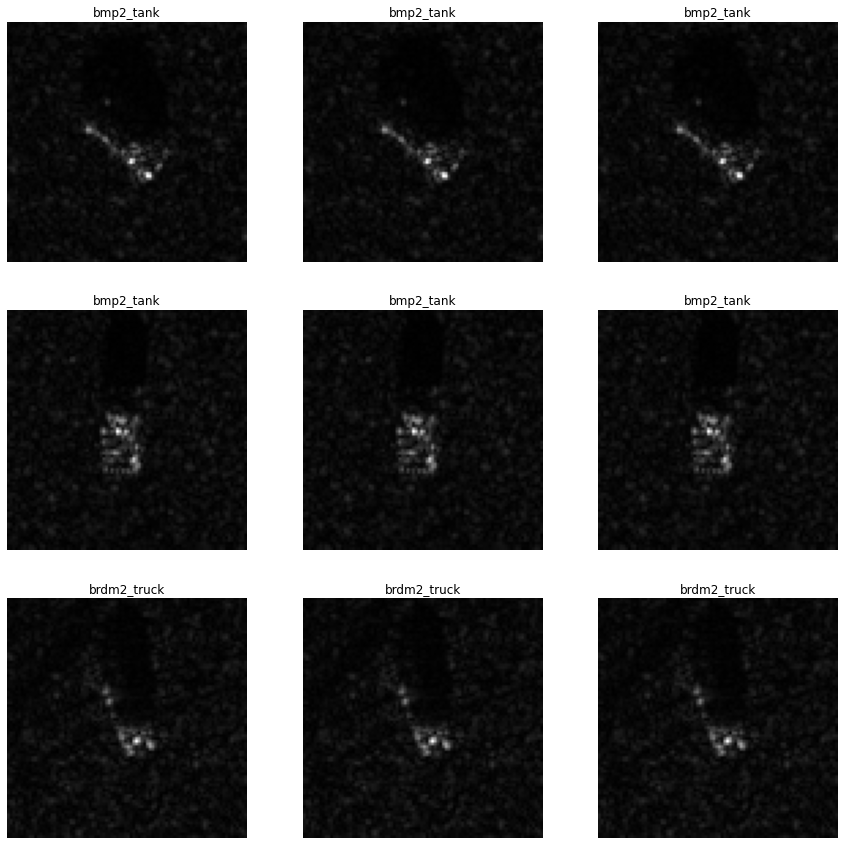

In [ ]:
import matplotlib.pyplot as plt

numx,numy = 3,3
fig, axs = plt.subplots(numx,numy,figsize=(15,15))
n = mag.shape[0]
R = np.random.permutation(n)
for i in range(numx):
    for j in range(numy):
        img = mag[R[i],:,:]
        #img = img/np.max(img)
        #img = np.log(img + 1e-3)
        axs[i,j].imshow(img,cmap='gray')
        axs[i,j].set_title(hdr[R[i],0])
        axs[i,j].axis('off')

##CNN Classifier
Here we explore a simple convolutional neural network for classification. We first define the network and train/test functions.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import datasets
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from scipy.special import softmax
import sys
import os

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        w = (32,64) #Number of channels in 1st and 2nd layers
        self.conv1 = nn.Conv2d(1, w[0], 3, 1)
        self.conv2 = nn.Conv2d(w[0], w[1], 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        f = 512  #Number of hidden nodes in fully connected layers
        self.fc1 = nn.Linear(w[1]*10*10, f)
        self.fc2 = nn.Linear(f, 10)
        self.bn1 = nn.BatchNorm1d(f)

    def forward(self, x): #88
        x = self.conv1(x) #86 
        x = F.relu(x)
        x = F.max_pool2d(x, 2) #43
        x = self.conv2(x) #41
        x = F.relu(x)
        x = F.max_pool2d(x, 4)  #10
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn1(x)   #batch normalization
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    #This is useful for extracting features from convolutional part of NN
    def convnet(self, x):
        x = self.conv1(x) #86 
        x = F.relu(x)
        x = F.max_pool2d(x, 2) #43
        x = self.conv2(x) #41
        x = F.relu(x)
        x = F.max_pool2d(x, 4)  #10
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        return x

def train(model, device, data_train, target_train, optimizer, epoch, batch_size):
    model.train()
    batch_idx = 0
    for idx in range(0,len(data_train),batch_size):
        data, target = data_train[idx:idx+batch_size], target_train[idx:idx+batch_size]
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == -1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(target_train),
                100. * batch_idx / int(len(data_train)/batch_size), loss.item()))
        batch_idx += 1


def test(model, device, data_test, target_test,name):
    batch_size = 1000
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for idx in range(0,len(data_test),batch_size):
            data, target = data_test[idx:idx+batch_size], target_test[idx:idx+batch_size]
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(target_test)

    print(name+' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(target_test),
        100. * correct / len(target_test)))

We now preprocess the data: convert labels to integers, train/test split, converting to Torch, randomly shuffling traiing set.

In [ ]:
#Convert targets to numerical labels
target = hdr[:,0].tolist()
classes = set(target)
label_dict = dict(zip(classes, np.arange(len(classes))))
labels = np.array([label_dict[t] for t in target],dtype=int)

#Training and testing split (based on papers)
angle = hdr[:,6].astype(int)
train_idx = angle == 17
test_idx = angle == 15

#Train testing split and convert to torch
data = torch.from_numpy(np.reshape(mag,(mag.shape[0],1,mag.shape[1],mag.shape[2]))).float()
labels = torch.from_numpy(labels).long()
data_train = data[train_idx,:,:,:]
data_test = data[test_idx,:,:,:]
target_train = labels[train_idx]
target_test = labels[test_idx]

all_indexes = np.arange(data.shape[0])
train_indexes_used = all_indexes[train_idx]
test_data_indexes = all_indexes[test_idx]

#Randomly shuffle training data
P = torch.randperm(np.sum(train_idx))
data_train = data_train[P,:,:,:]
target_train = target_train[P]

Now we train the convolutional neural network.

In [ ]:
#Training settings
cuda = True   #Use GPU acceleration (Edit->Notebook Settings and enable GPU)
batch_size = 150
learning_rate = 1    #Learning rate
gamma = 0.9     #Learning rate step
epochs = 50

#Cuda and optimizer/scheduler
use_cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

#Main training loop
for epoch in range(1, epochs + 1):
    train(model, device, data_train, target_train, optimizer, epoch, batch_size)
    print('\nEpoch: %d'%epoch)
    test(model, device, data_test, target_test, 'Test ')
    test(model, device, data_train, target_train, 'Train')
    scheduler.step()

#Save model
torch.save(model.state_dict(), 'SAR10_cnn.pt')

#Save encoded data
model.eval()
with torch.no_grad():
    Y = model.convnet(data.to(device)).cpu().numpy()  
    np.savez_compressed('SAR10_cnn.npz',data=Y,labels=labels.numpy())

#Graph learning
As a simple first step, we can apply graph-based learning to the CNN encoded features.

In [ ]:
pip install -q graphlearning

     |████████████████████████████████| 49 kB 3.9 MB/s 
     |████████████████████████████████| 646 kB 13.7 MB/s 
     |████████████████████████████████| 93 kB 1.6 MB/s 


In [ ]:
import graphlearning as gl

In [ ]:
M = np.load('SAR10_cnn.npz')
X = M['data']   #Encoded data
L = M['labels'] #Labels

print(X.shape)
print(L.shape)

W_cnn = gl.knn_weight_matrix(20,data=X)

num_train_per_class = 10
train_ind = gl.randomize_labels(L, num_train_per_class)
train_labels = L[train_ind]

(6874, 6400)
(6874,)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [ ]:
#Run Laplace learning
labels_laplace = gl.graph_ssl(W_cnn,train_ind,train_labels,algorithm='laplace')

#Run Poisson learning
labels_poisson = gl.graph_ssl(W_cnn,train_ind,train_labels,algorithm='poisson')

# compare results -- compute accuracy
print('With', num_train_per_class, 'labels per class:') 
print('Laplace learning: %.2f%%'%gl.accuracy(L,labels_laplace,len(train_ind)))

print('Poisson learning: %.2f%%'%gl.accuracy(L,labels_poisson,len(train_ind)))

With 10 labels per class:
Laplace learning: 82.96%
Poisson learning: 75.83%


In [ ]:
D = data.numpy().reshape(-1, 88*88)
W_raw = gl.knn_weight_matrix(20, data=D)

kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [ ]:
L = labels.numpy()

num_train_per_class = 50
train_ind = gl.randomize_labels(L, num_train_per_class)
train_labels = L[train_ind]

In [ ]:
#Run Laplace learning
laplace_labels = gl.graph_ssl(W_raw,train_ind,train_labels,algorithm='laplace')

test_set_laplace_labels = laplace_labels[test_data_indexes]
test_set_labels = L[test_data_indexes]

print('Using %d labels per class'%int(len(train_ind)/10))
print('Laplace Test Accuracy: %.2f%%'%gl.accuracy(test_set_laplace_labels,test_set_labels,len(train_ind)))

# compare results -- compute accuracy
print('With', num_train_per_class, 'labels per class:') 
print('Laplace learning: %.2f%%'%gl.accuracy(L,laplace_labels,len(train_ind)))

Using 50 labels per class
Laplace Test Accuracy: 80.28%
With 50 labels per class:
Laplace learning: 83.78%


In [ ]:
print(laplace_labels[0:100])
print(L[0:100])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 4 1
 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 5 1 6 6 1 1 1 1 1 4 4 1 1 1 1 1 1 5 1 4 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
print(test_set_laplace_labels)
print(test_set_labels)

[1 1 1 ... 4 4 5]
[1 1 1 ... 4 4 4]


# VAE

In [ ]:
import torch
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        num_channels = 88*88
        new_ch = [512, 128]
        hf = 16

        # Encode
        self.fc1 = nn.Linear(num_channels, new_ch[0])
        self.fc2 = nn.Linear(new_ch[0], new_ch[1])
        self.fc31 = nn.Linear(new_ch[1], hf)
        self.fc32 = nn.Linear(new_ch[1], hf)

        # Decode
        self.fc4 = nn.Linear(hf, new_ch[1])
        self.fc5 = nn.Linear(new_ch[1], new_ch[0])
        self.fc6 = nn.Linear(new_ch[0], num_channels)

        #self.dropout1 = nn.Dropout(0.5)
        #self.bn = nn.BatchNorm1d(hf)

    def encode(self, x):
        x = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(x))
        return self.fc31(h2), self.fc32(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = F.relu(self.fc4(z))
        h5 = F.relu(self.fc5(z))
        return torch.sigmoid(self.fc6(h5))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, num_channels))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, num_channels), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(data_loader.dataset)))

In [ ]:
no_cuda = False
num_channels = 88*88
batch_size = 128
log_interval = 20    #how many batches to wait before logging training status
epochs = 50

#GPU settings
cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

#Convert to torch dataloaders (already done in this case)
normalized_data = (data/torch.max(data)).float()
target = labels
SAR10 = MyDataset(data, target) 
data_loader = DataLoader(SAR10, batch_size = batch_size, shuffle = True, **kwargs)

#Put model on GPU and set up optimizer
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
#Training epochs
for epoch in range(1, epochs + 1):
    train(epoch)

Train Epoch: 1 [0/6874 (0%)]	Loss: 5374.662109
Train Epoch: 1 [2560/6874 (37%)]	Loss: 1757.917114
Train Epoch: 1 [5120/6874 (74%)]	Loss: 1610.990601
====> Epoch: 1 Average loss: 2059.6182
Train Epoch: 2 [0/6874 (0%)]	Loss: 1597.633545
Train Epoch: 2 [2560/6874 (37%)]	Loss: 1589.550659
Train Epoch: 2 [5120/6874 (74%)]	Loss: 1589.344604
====> Epoch: 2 Average loss: 1589.4859
Train Epoch: 3 [0/6874 (0%)]	Loss: 1580.110474
Train Epoch: 3 [2560/6874 (37%)]	Loss: 1594.523438
Train Epoch: 3 [5120/6874 (74%)]	Loss: 1582.018311
====> Epoch: 3 Average loss: 1575.5683
Train Epoch: 4 [0/6874 (0%)]	Loss: 1558.335205
Train Epoch: 4 [2560/6874 (37%)]	Loss: 1575.954346
Train Epoch: 4 [5120/6874 (74%)]	Loss: 1562.464478
====> Epoch: 4 Average loss: 1566.3853
Train Epoch: 5 [0/6874 (0%)]	Loss: 1579.362305
Train Epoch: 5 [2560/6874 (37%)]	Loss: 1541.465210
Train Epoch: 5 [5120/6874 (74%)]	Loss: 1572.835083
====> Epoch: 5 Average loss: 1562.7271
Train Epoch: 6 [0/6874 (0%)]	Loss: 1552.723755
Train Epoch: 

In [ ]:
#Encode the dataset and save to npz file
model.eval()
with torch.no_grad():
    mu, logvar = model.encode(normalized_data.to(device).view(-1, num_channels))
    Y = mu.cpu().numpy()
    np.savez_compressed('SAR10_vae.npz',data=Y,labels=target.numpy())

In [ ]:
import graphlearning as gl
import numpy as np

#Load labels, knndata, and build 10-nearest neighbor weight matrix

#Variational autoencoder weight matrix (can use commented line below, 
#but we're showing how to use the embedding computed above)
#W_vae = gl.knn_weight_matrix(10,dataset='mnist',metric='vae')
M = np.load('SAR10_vae.npz')
X = M['data']
L = M['labels']
W_vae = gl.knn_weight_matrix(20,data=X)

#Randomly chose training datapoints 
num_train_per_class = 10
train_ind = gl.randomize_labels(L, num_train_per_class)
train_labels = L[train_ind]

#Run Laplace and Poisson learning
labels_vae = gl.graph_ssl(W_vae,train_ind,train_labels,algorithm='laplace')

#Print accuracy
print('Using %d labels per class'%int(len(train_ind)/10))
print('Accuracy using VAE: %.2f'%gl.accuracy(L,labels_vae,10))

kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Using 10 labels per class
Accuracy using VAE: 55.73


In [ ]:
import graphlearning as gl
import numpy as np

#Load labels, knndata, and build 10-nearest neighbor weight matrix

#Variational autoencoder weight matrix (can use commented line below, 
#but we're showing how to use the embedding computed above)
#W_vae = gl.knn_weight_matrix(10,dataset='mnist',metric='vae')
M = np.load('SAR10_vae.npz')
X = M['data']
L = labels.numpy()
W_vae = gl.knn_weight_matrix(20,data=X);

#Randomly chose training datapoints 
num_train_per_class = 10
train_ind = gl.randomize_labels(L, num_train_per_class)
train_labels = L[train_ind]

#Run Laplace and Poisson learning
labels_vae = gl.graph_ssl(W_vae,train_ind,train_labels,algorithm='laplace')

#Print accuracy
print('Using %d labels per class'%int(len(train_ind)/10))
print('Accuracy using VAE: %.2f'%gl.accuracy(L,labels_vae,10))

kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Using 10 labels per class
Accuracy using VAE: 46.20


# CNN VAE

In [ ]:
import imageio
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import torchvision.transforms as transforms

to_pil_image = transforms.ToPILImage()

def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('generated_images.gif', imgs)

def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"output{epoch}.jpg")

def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.jpg')
    plt.show()

In [ ]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import Dataset, DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from torch.optim.lr_scheduler import StepLR
import matplotlib
from torchvision.utils import make_grid

matplotlib.style.use('ggplot')

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

# Loss function (POTENTIALLY CHANGE BCE TO NLL)
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training function
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()

    train_loss = running_loss / counter 
    return train_loss

# Validation function
def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data = data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction

    val_loss = running_loss / counter
    return val_loss, recon_images

In [ ]:
kernel_size = 3 # (3, 3) kernel
num_classes = 10
init_channels = 8 # initial number of filters
image_channels = 1
latent_dim = 32 # latent dimension for sampling

# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*3, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*3, out_channels=init_channels*6, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*6, out_channels=init_channels*10, kernel_size=kernel_size, 
            stride=2, padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear((init_channels*10)*10*10, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_log_var = nn.Linear(256, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 128)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=128, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0, output_padding=1, dilation=3
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=0, output_padding=1, dilation=3
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1, output_padding=1, dilation=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1, output_padding=1, dilation=1
        )

        self.dropout1 = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm1d(32)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x): #88
        # encoding
        x = F.relu(self.enc1(x)) #88
        x = F.adaptive_avg_pool2d(x, 44) #44
        x = F.relu(self.enc2(x)) #44
        x = F.adaptive_avg_pool2d(x, 22) #22
        x = F.relu(self.enc3(x)) #22
        x = F.relu(self.enc4(x)) #10
        batch, _, _, _ = x.shape
        x = x.reshape(batch, -1)
        hidden = self.fc1(x) 
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var) #(64, 32)
        z = self.dropout1(z)
        z = self.bn1(z)
        z = self.fc2(z) #(64, 64)
        z = z.view(-1, 128, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z)) #8
        x = F.relu(self.dec2(x)) #22
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

    def encode(self, x):
        x = F.relu(self.enc1(x)) #88
        x = F.adaptive_avg_pool2d(x, 44) #44
        x = F.relu(self.enc2(x)) #44
        x = F.adaptive_avg_pool2d(x, 22) #22
        x = F.relu(self.enc3(x)) #22
        x = F.relu(self.enc4(x)) #10
        x = x.reshape(x.shape[0], -1)
        return x

In [ ]:
kernel_size = 3 # (3, 3) kernel
num_classes = 10
init_channels = 8 # initial number of filters
image_channels = 1
latent_dim = 32 # latent dimension for sampling

# define a Conv VAE
class XCVAE(nn.Module):
    def __init__(self):
        super(XCVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64*11*11, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0, output_padding=1, dilation=3
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=0, output_padding=1, dilation=3
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1, output_padding=1, dilation=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1, output_padding=1, dilation=1
        )
        self.droupout1 = nn.Dropout(0.5)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x): #88
        # encoding
        x = F.relu(self.enc1(x)) #88
        x = F.max_pool2d(x, 2) #44
        x = F.relu(self.enc2(x)) #44
        x = F.max_pool2d(x, 2) #22
        x = F.relu(self.enc3(x)) #22
        x = F.relu(self.enc4(x)) #11
        batch, _, _, _ = x.shape
        x = self.droupout1(x)
        x = x.reshape(batch, -1)
        hidden = self.fc1(x) #(64*11*11, 128)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var) #(64, 16)
        z = self.fc2(z) #(64, 64)
        z = z.view(-1, 64, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z)) #8
        x = F.relu(self.dec2(x)) #22
        x = self.droupout1(x)
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

    def encode(self, x):
        x = F.relu(self.enc1(x)) #88
        x = F.max_pool2d(x, 2) #44
        x = F.relu(self.enc2(x)) #44
        x = F.max_pool2d(x, 2) #22
        x = F.relu(self.enc3(x)) #22
        x = F.relu(self.enc4(x)) #11
        x = self.droupout1(x)
        x = x.reshape(x.shape[0], -1)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize the model
model = XCVAE().to(device)

# set the learning parameters
lr = 0.001
epochs = 50
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

cuda = True
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

In [ ]:
#Convert targets to numerical labels
target = hdr[:,0].tolist()
classes = set(target)
label_dict = dict(zip(classes, np.arange(len(classes))))
labels = np.array([label_dict[t] for t in target],dtype=int)

#Training and testing split (based on papers)
angle = hdr[:,6].astype(int)
train_idx = angle == 17
test_idx = angle == 15

#Train testing split and convert to torch
data = torch.from_numpy(np.reshape(mag,(mag.shape[0],1,mag.shape[1],mag.shape[2]))).float()
#data = data / torch.max(data)
labels = torch.from_numpy(labels).long()
data_train = data[train_idx,:,:,:]
data_test = data[test_idx,:,:,:]
target_train = labels[train_idx]
target_test = labels[test_idx]

# Creating indexes for later graph learning use
all_indexes = np.arange(data.shape[0])
train_indexes_used = all_indexes[train_idx]
test_data_indexes = all_indexes[test_idx]

#Randomly shuffle training data
P = torch.randperm(np.sum(train_idx))
data_train = data_train[P,:,:,:]
target_train = target_train[P]

#Convert to torch dataloaders
dTr = data_train
dV = data_test
tTr = target_train
tV = target_test

SAR_train = MyDataset(dTr, tTr) 
trainloader = DataLoader(SAR_train, batch_size = batch_size, shuffle = True, **kwargs)

SAR_validate = MyDataset(dV, tV) 
testloader = DataLoader(SAR_validate, batch_size = batch_size, shuffle = True, **kwargs)

Epoch 1 of 50


  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
58it [00:02, 20.50it/s]                        
51it [00:00, 102.47it/s]                        


Train Loss: 223161.6890
Val Loss: 140099.8477
Epoch 2 of 50


58it [00:02, 24.43it/s]                        
51it [00:00, 104.66it/s]                        


Train Loss: 132481.2012
Val Loss: 112314.9357
Epoch 3 of 50


58it [00:02, 24.80it/s]                        
51it [00:00, 102.89it/s]                        


Train Loss: 113056.3621
Val Loss: 99718.9182
Epoch 4 of 50


58it [00:02, 24.99it/s]                        
51it [00:00, 100.34it/s]                        


Train Loss: 107974.1822
Val Loss: 98635.0746
Epoch 5 of 50


58it [00:02, 24.57it/s]                        
51it [00:00, 102.55it/s]                        


Train Loss: 107203.3065
Val Loss: 98044.7173
Epoch 6 of 50


58it [00:02, 24.85it/s]                        
51it [00:00, 101.78it/s]                        


Train Loss: 106907.0743
Val Loss: 97843.5497
Epoch 7 of 50


58it [00:02, 24.47it/s]                        
51it [00:00, 101.82it/s]                        


Train Loss: 106700.3965
Val Loss: 97709.9535
Epoch 8 of 50


58it [00:02, 24.99it/s]                        
51it [00:00, 99.67it/s]                         


Train Loss: 106532.7220
Val Loss: 97404.5988
Epoch 9 of 50


58it [00:02, 24.47it/s]                        
51it [00:00, 101.93it/s]                        


Train Loss: 106341.0871
Val Loss: 97379.4384
Epoch 10 of 50


58it [00:02, 25.44it/s]                        
51it [00:00, 103.91it/s]                        


Train Loss: 106180.5286
Val Loss: 97111.7975
Epoch 11 of 50


58it [00:02, 24.63it/s]                        
51it [00:00, 98.07it/s]                         

Train Loss: 106048.7004
Val Loss: 97065.9449
Epoch 12 of 50



58it [00:02, 24.82it/s]                        
51it [00:00, 98.18it/s]                        

Train Loss: 105799.2980
Val Loss: 96858.6489
Epoch 13 of 50



58it [00:02, 24.51it/s]                        
51it [00:00, 103.14it/s]                        


Train Loss: 105173.2453
Val Loss: 96857.0297
Epoch 14 of 50


58it [00:02, 25.06it/s]                        
51it [00:00, 104.39it/s]                        


Train Loss: 105379.2373
Val Loss: 96490.4790
Epoch 15 of 50


58it [00:02, 24.46it/s]                        
51it [00:00, 99.29it/s]                         

Train Loss: 104374.0515
Val Loss: 96073.1070
Epoch 16 of 50



58it [00:02, 24.78it/s]                        
51it [00:00, 100.56it/s]                        


Train Loss: 104221.7790
Val Loss: 95878.5018
Epoch 17 of 50


58it [00:02, 25.01it/s]                        
51it [00:00, 102.59it/s]                        


Train Loss: 104275.7755
Val Loss: 95983.3012
Epoch 18 of 50


58it [00:02, 24.60it/s]                        
51it [00:00, 102.58it/s]                        


Train Loss: 103696.8290
Val Loss: 95553.6891
Epoch 19 of 50


58it [00:02, 24.68it/s]                        
51it [00:00, 98.40it/s]                        

Train Loss: 103837.3777
Val Loss: 95615.5834
Epoch 20 of 50



58it [00:02, 25.07it/s]                        
51it [00:00, 99.44it/s]                         


Train Loss: 103445.0335
Val Loss: 95566.7869
Epoch 21 of 50


58it [00:02, 24.30it/s]                        
51it [00:00, 100.70it/s]                        


Train Loss: 102682.4714
Val Loss: 95303.0333
Epoch 22 of 50


58it [00:02, 25.12it/s]                        
51it [00:00, 102.61it/s]                        


Train Loss: 102715.5407
Val Loss: 95418.8481
Epoch 23 of 50


58it [00:02, 24.38it/s]                        
51it [00:00, 99.77it/s]                         


Train Loss: 102706.0583
Val Loss: 95007.1910
Epoch 24 of 50


58it [00:02, 24.98it/s]                        
51it [00:00, 100.06it/s]                        

Train Loss: 102556.7258
Val Loss: 94589.8776
Epoch 25 of 50



58it [00:02, 24.27it/s]                        
51it [00:00, 101.59it/s]                        


Train Loss: 102639.7675
Val Loss: 94806.7770
Epoch 26 of 50


58it [00:02, 24.95it/s]                        
51it [00:00, 101.55it/s]                        


Train Loss: 102486.9391
Val Loss: 94970.7142
Epoch 27 of 50


58it [00:02, 24.71it/s]                        
51it [00:00, 99.19it/s]                         


Train Loss: 102057.1532
Val Loss: 94507.9895
Epoch 28 of 50


58it [00:02, 24.78it/s]                        
51it [00:00, 100.30it/s]                        

Train Loss: 101709.6441
Val Loss: 94321.6415
Epoch 29 of 50



58it [00:02, 24.76it/s]                        
51it [00:00, 101.92it/s]                        


Train Loss: 101256.8218
Val Loss: 94299.4877
Epoch 30 of 50


58it [00:02, 24.92it/s]                        
51it [00:00, 101.62it/s]                        


Train Loss: 101553.1354
Val Loss: 93809.2339
Epoch 31 of 50


58it [00:02, 24.38it/s]                        
51it [00:00, 99.41it/s]                         


Train Loss: 101225.2806
Val Loss: 94120.5897
Epoch 32 of 50


58it [00:02, 24.88it/s]                        
51it [00:00, 101.04it/s]                        

Train Loss: 101442.9190
Val Loss: 93908.4083
Epoch 33 of 50



58it [00:02, 24.42it/s]                        
51it [00:00, 102.65it/s]                        


Train Loss: 101314.0075
Val Loss: 93821.3070
Epoch 34 of 50


58it [00:02, 24.53it/s]                        
51it [00:00, 100.79it/s]                        


Train Loss: 101428.2954
Val Loss: 94291.0452
Epoch 35 of 50


58it [00:02, 24.41it/s]                        
51it [00:00, 100.70it/s]                        


Train Loss: 100866.5915
Val Loss: 94054.3754
Epoch 36 of 50


58it [00:02, 24.78it/s]                        
51it [00:00, 98.16it/s]                        

Train Loss: 100748.4734
Val Loss: 93706.7640
Epoch 37 of 50



58it [00:02, 24.67it/s]                        
51it [00:00, 98.02it/s]                        

Train Loss: 100399.9011
Val Loss: 93606.7836
Epoch 38 of 50



58it [00:02, 24.73it/s]                        
51it [00:00, 102.54it/s]                        


Train Loss: 100287.6946
Val Loss: 93509.4120
Epoch 39 of 50


58it [00:02, 24.47it/s]                        
51it [00:00, 96.94it/s]                         

Train Loss: 100624.2022
Val Loss: 93890.9107
Epoch 40 of 50



58it [00:02, 24.70it/s]                        
51it [00:00, 98.73it/s]                         

Train Loss: 100438.0604
Val Loss: 94068.5416
Epoch 41 of 50



58it [00:02, 24.57it/s]                        
51it [00:00, 101.54it/s]                        


Train Loss: 100447.8102
Val Loss: 93616.9307
Epoch 42 of 50


58it [00:02, 24.70it/s]                        
51it [00:00, 100.18it/s]                        

Train Loss: 100752.3751
Val Loss: 93347.0525
Epoch 43 of 50



58it [00:02, 24.79it/s]                        
51it [00:00, 97.67it/s]                        

Train Loss: 100046.1171
Val Loss: 93372.5703
Epoch 44 of 50



58it [00:02, 24.37it/s]                        
51it [00:00, 99.00it/s]                         

Train Loss: 100586.6400
Val Loss: 92883.0546
Epoch 45 of 50



58it [00:02, 24.30it/s]                        
51it [00:00, 99.74it/s]                         


Train Loss: 99815.4149
Val Loss: 92877.5921
Epoch 46 of 50


58it [00:02, 24.83it/s]                        
51it [00:00, 101.93it/s]                        


Train Loss: 99803.2700
Val Loss: 93108.2119
Epoch 47 of 50


58it [00:02, 23.98it/s]                        
51it [00:00, 98.83it/s]                         


Train Loss: 100343.4569
Val Loss: 92938.5661
Epoch 48 of 50


58it [00:02, 24.69it/s]                        
51it [00:00, 97.90it/s]                         

Train Loss: 100132.0324
Val Loss: 93556.4496
Epoch 49 of 50



58it [00:02, 24.21it/s]                        
51it [00:00, 100.26it/s]                        


Train Loss: 99744.0796
Val Loss: 92991.3686
Epoch 50 of 50


58it [00:02, 24.63it/s]                        
51it [00:00, 101.07it/s]                        


Train Loss: 99660.2384
Val Loss: 92912.6819


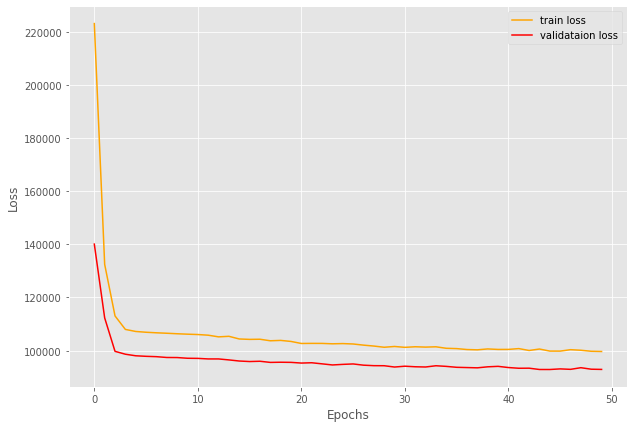

TRAINING COMPLETE


In [ ]:
train_loss = []
valid_loss = []
batch_size = 64
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")

    train_epoch_loss = train(
        model, trainloader, SAR_train, device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, testloader, SAR_validate, device, criterion
    )

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)

    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

# save the reconstructions as a .gif file
image_to_vid(grid_images)

# save the loss plots to disk
save_loss_plot(train_loss, valid_loss)
print('TRAINING COMPLETE')

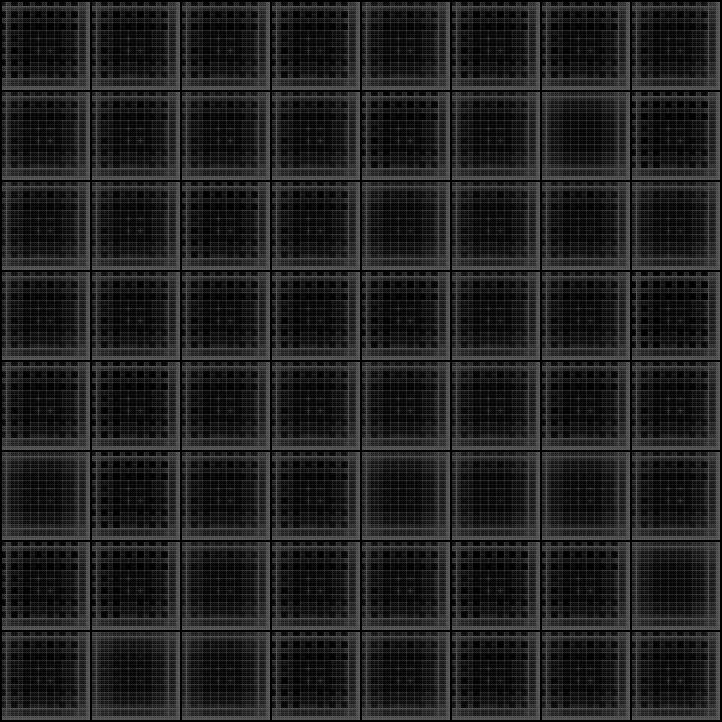

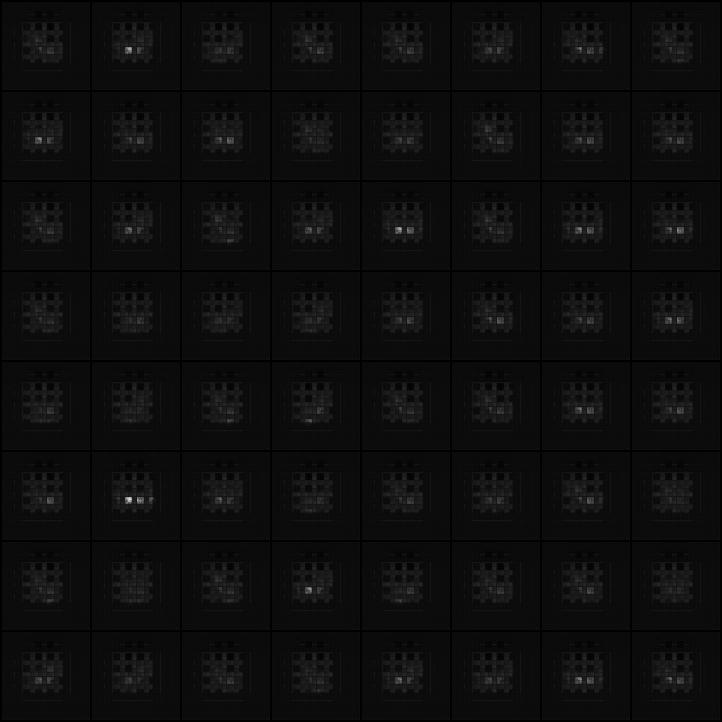

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

epoch1 = cv2.imread('output1.jpg')
cv2_imshow(epoch1)

epoch50 = cv2.imread('output50.jpg')
cv2_imshow(epoch50)

In [ ]:
#Save model
torch.save(model.state_dict(), 'SAR10_cvae.pt')

CVAE_data = data

#Encode the dataset and save to npz file
with torch.no_grad():
    mu = model.encode(CVAE_data.to(device))
    Y = mu.cpu().numpy()
    np.savez_compressed('SAR10_cvae.npz',data=Y,labels=labels)

In [ ]:
pip install -q graphlearning

     |████████████████████████████████| 49 kB 4.0 MB/s 
     |████████████████████████████████| 646 kB 19.2 MB/s 
     |████████████████████████████████| 93 kB 260 kB/s 


In [ ]:
import graphlearning as gl

M = np.load('SAR10_cvae.npz')
X = M['data']   #Encoded data
L = M['labels'] #Labels

print(X.shape)
print(L.shape)

W_cvae = gl.knn_weight_matrix(20,data=X)

(6874, 7744)
(6874,)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [ ]:
num_train_per_class = 50
train_ind = gl.randomize_labels(L, num_train_per_class) #use angle=17 train labels
train_labels = L[train_ind]

In [ ]:
#Run Laplace learning
laplace_labels = gl.graph_ssl(W_cvae,train_ind,train_labels,algorithm='laplace')

test_set_laplace_labels = laplace_labels[test_data_indexes]
test_set_labels = L[test_data_indexes]

print('Using %d labels per class'%int(len(train_ind)/10))
print('Laplace Test Accuracy: %.2f%%'%gl.accuracy(test_set_laplace_labels,test_set_labels,len(train_ind)))

# compare results -- compute accuracy
print('With', num_train_per_class, 'labels per class:') 
print('Laplace learning: %.2f%%'%gl.accuracy(L,laplace_labels,len(train_ind)))

Using 50 labels per class
Laplace Test Accuracy: 80.69%
With 50 labels per class:
Laplace learning: 83.31%


In [ ]:
test_set_labels = L[test_data_indexes]
sum = 0
num_train_per_class = 100

for i in range(20):

  train_ind = gl.randomize_labels(L, num_train_per_class) #use angle=17 train labels
  train_labels = L[train_ind]

  #Run Laplace learning
  laplace_labels = gl.graph_ssl(W_cvae,train_ind,train_labels,algorithm='laplace')

  test_set_laplace_labels = laplace_labels[test_data_indexes]
  #print(gl.accuracy(test_set_laplace_labels,test_set_labels,len(train_ind)))
  sum += gl.accuracy(test_set_laplace_labels,test_set_labels,len(train_ind))

average = sum / 20
print(average)

84.43032228778938
86.29142078983205
84.47571493418066
84.33953699500681
83.34089877439855
86.06445755787563
84.11257376305039
85.38356786200636
84.70267816613709
84.38492964139809
83.74943259192011
86.06445755787563
85.38356786200636
85.88288697231049
83.84021788470268
85.5651384475715
84.29414434861552
84.56650022696323
84.88424875170223
84.52110758057195
84.81389014979572


10 per class: 69.03

20 per class: 81.08

30 per class: 86.14

40 per class: 90.17

50 per class: 92.28

60 per class: 93.42

70 per class: 94.61

80 per class: 94.76

90 per class: 94.94

100 per class: 95.60



In [ ]:
accs = [69.03, 81.08, 86.14, 90.17, 92.28, 93.42, 94.61, 94.76, 94.94, 95.60]
train_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

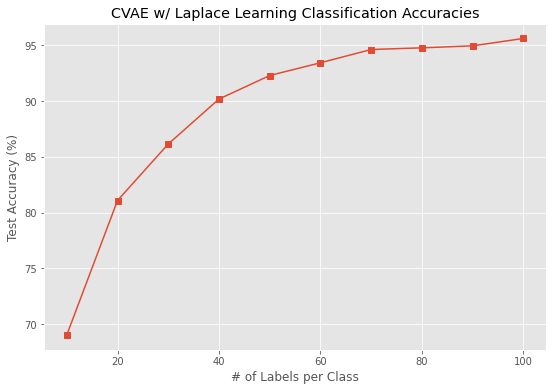

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(train_sizes, accs, '-s')

ax.set_title("CVAE w/ Laplace Learning Classification Accuracies")
plt.xlabel("# of Labels per Class")
plt.ylabel("Test Accuracy (%)")

plt.show()
plt.savefig('CVAE_Accuracy.png')

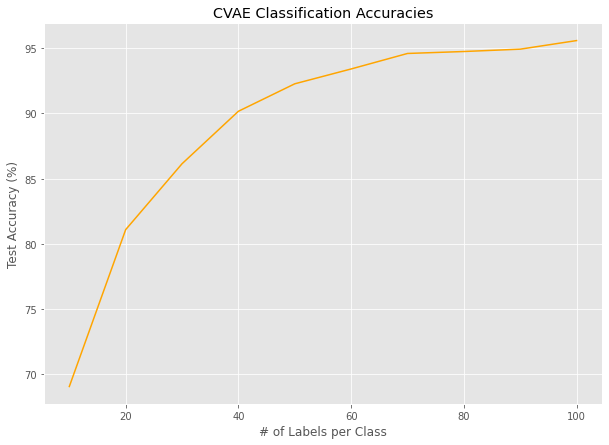

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_sizes, accs, color='orange')
plt.title('CVAE Classification Accuracies')
plt.xlabel('# of Labels per Class')
plt.ylabel('Test Accuracy (%)')
plt.show()

*run* 1: 93.67%

run 2: 82.13%

run 3: 84.42%

run 4(no dropout): 86.42%

In [ ]:
#Run Laplace learning
labels_laplace = gl.graph_ssl(W_cvae,train_ind,train_labels,algorithm='laplace')

#Run Poisson learning
labels_poisson = gl.graph_ssl(W_cvae,train_ind,train_labels,algorithm='poisson')

# compare results -- compute accuracy
print('With', num_train_per_class, 'labels per class:') 
print('Laplace learning: %.2f%%'%gl.accuracy(L,labels_laplace,len(train_ind))) # compare to angle=15 labels

print('Poisson learning: %.2f%%'%gl.accuracy(L,labels_poisson,len(train_ind)))

With 100 labels per class:
Laplace learning: 89.51%
Poisson learning: 73.49%


#Using Pre-trained Models

In [ ]:
#Load the pretrained VGG-16 BN model
vgg16 = torchvision.models.vgg16_bn(pretrained=True) 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Set requires_grad = False for all parameters, so that we do not train these layers
for param in vgg16.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [ ]:
class x_vgg16(nn.Module):
    def __init__(self,output_layer = 'features'):
        super().__init__()
        self.pretrained = torchvision.models.vgg16_bn(pretrained=True)
        self.output_layer = output_layer
        self.layers = list(self.pretrained._modules.keys())
        self.layer_count = 0
        for l in self.layers:
            if l != self.output_layer:
                self.layer_count += 1
            else:
                break
        for i in range(1,len(self.layers)-self.layer_count):
            self.dummy_var = self.pretrained._modules.pop(self.layers[-i])
        
        self.net = nn.Sequential(self.pretrained._modules)
        self.pretrained = None

    def forward(self,x):
        x = self.net(x)
        return x

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = x_vgg16()
model = model.to(device)

In [ ]:
# Loading data for training

#Convert targets to numerical labels
target = hdr[:,0].tolist()
classes = set(target)
label_dict = dict(zip(classes, np.arange(len(classes))))
L = np.array([label_dict[t] for t in target],dtype=int)

#Training and testing split (based on papers)
angle = hdr[:,6].astype(int)
train_idx = angle == 17
test_idx = angle == 15

# Reshape data
np_data = (np.reshape(mag,(mag.shape[0],1,mag.shape[1],mag.shape[2])))

# Creating indexes for later graph learning use
all_indexes = np.arange(data.shape[0])
train_indexes_used = all_indexes[train_idx]
test_data_indexes = all_indexes[test_idx]

#Convert to 3 color channels
data3c = np.reshape(np_data,(np_data.shape[0],88,88))
data3c = np.stack((data3c,data3c,data3c),axis=1)
print(data3c.shape)

(6874, 3, 88, 88)


In [ ]:
#Convert to torch
pt_data = torch.from_numpy(data3c).float()
labels = torch.from_numpy(L).long()
'''
pt_data = pt_data.cuda()
labels = labels.cuda()
'''
#Data transforms
data_transforms = transforms.Compose([
        transforms.Resize(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

dataset = MyDataset(pt_data, labels, transform=data_transforms)

dataloader = DataLoader(dataset, batch_size = 64)

In [ ]:
vgg_enc = np.empty(shape=(1, 1))

with torch.no_grad():
  for images, labels in dataloader:
    output = model.forward(images.to(device))
    np_out = output.reshape(-1, 1).cpu().numpy()
    print(np_out.shape)
    vgg_enc = np.concatenate((vgg_enc, np_out))


In [ ]:
vgg_enc = vgg_enc[1:, :]

In [ ]:
vgg_enc = vgg_enc.reshape(6874, 512*7*7)

In [ ]:
from sklearn.decomposition import IncrementalPCA

## Dimensional Reduction Method
def DL_Method(I, numComponents = 75):
    n_batches = 128
    inc_pca = IncrementalPCA(n_components=numComponents)
    for X_batch in np.array_split(I, n_batches):
        inc_pca.partial_fit(X_batch)
    X_ipca = inc_pca.transform(I)
    RI = np.reshape(X_ipca, (I.shape[0], numComponents))
    return RI

In [ ]:
from sklearn.decomposition import PCA

#Function to perform PCA on data
def PCA_Method(I, n_components = 75):
  pca = PCA(n_components=n_components)
  pca_image = pca.fit_transform(I)
  print("Total Variation (%d components): "%n_components, np.sum(pca.explained_variance_ratio_))
  pca_image = pca_image.reshape(-1, n_components)
  print("pca image shape: ", pca_image.shape)

  return pca_image

In [ ]:
reduced_vgg = PCA_Method(vgg_enc, n_components=5000)

Total Variation (5000 components):  0.9670783837978388
pca image shape:  (6874, 5000)


In [ ]:
import graphlearning as gl

In [ ]:
W_vgg = gl.knn_weight_matrix(20,data=reduced_vgg)

kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [ ]:
num_train_per_class = 50
train_ind = gl.randomize_labels(L, num_train_per_class) #use angle=17 train labels
train_labels = L[train_ind]

In [ ]:
#Run Laplace learning
laplace_labels = gl.graph_ssl(W_vgg,train_ind,train_labels,algorithm='laplace')

test_set_laplace_labels = laplace_labels[test_data_indexes]
test_set_labels = L[test_data_indexes]

print('Using %d labels per class'%int(len(train_ind)/10))
print('Laplace Test Accuracy: %.2f%%'%gl.accuracy(test_set_laplace_labels,test_set_labels,len(train_ind)))

# compare results -- compute accuracy
print('With', num_train_per_class, 'labels per class:') 
print('Laplace learning: %.2f%%'%gl.accuracy(L,laplace_labels,len(train_ind)))

Using 50 labels per class
Laplace Test Accuracy: 13.47%
With 50 labels per class:
Laplace learning: 21.96%
